In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Mount Google Drive if using Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or unable to load: {image_path}")

    image = image.astype(np.float64) / 255.0

    # Convert the image to a suitable format for processing
    img = Image.fromarray((image * 255).astype(np.uint8))
    img = cv2.cvtColor(np.array(img), cv2.COLOR_GRAY2RGB)
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Kernel for morphologyEx
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))

    # Apply MORPH_BLACKHAT to grayScale image to highlight dark regions
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)

    # Apply thresholding to blackhat
    _, threshold = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # Inpaint with the original image and threshold image to remove nerves
    final_image = cv2.inpaint(img, threshold, 1, cv2.INPAINT_TELEA)
    final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY)

    # Normalize the image back to range [0, 1]
    image_without_nerves = final_image.astype(np.float64) / 255.0

    # Fourier transformation
    f_transform = np.fft.fft2(image_without_nerves)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.log(np.abs(f_shift) + 1)

    # Mask to focus on the optic disc and cup region
    rows, cols = image.shape
    mask = np.zeros((rows, cols), np.uint8)
    center = (rows // 2, cols // 2)
    radius = min(rows, cols) // 4
    cv2.circle(mask, center, radius, 1, thickness=-1)

    # Apply the mask to the Fourier transformed image
    f_shift_masked = f_shift * mask

    # Inverse Fourier transformation
    f_ishift = np.fft.ifftshift(f_shift_masked)
    image_back = np.fft.ifft2(f_ishift)
    image_back = np.abs(image_back)

    # Resize image to a standard size
    image_back = cv2.resize(image_back, (224, 224))

    # Convert image to float32 and normalize pixel values
    image_back = image_back.astype(np.float32) / 255.0

    return image_back, magnitude_spectrum

In [46]:
# Load and preprocess dataset
def load_dataset(dataset_path):
    images = []
    labels = []
    class_folders = sorted(os.listdir(dataset_path))
    for i, class_folder in enumerate(class_folders):
        class_folder_path = os.path.join(dataset_path, class_folder)
        for image_file in os.listdir(class_folder_path):
            image_path = os.path.join(class_folder_path, image_file)
            # Preprocess image
            image = preprocess_image(image_path)
            images.append(image)
            labels.append(i)
    return np.array(images), np.array(labels)

In [50]:
# Load an example image
example_image_path = "/content/drive/MyDrive/master_dataset/test/class1/Im262.jpg"
# Preprocess the example image
preprocessed_image, magnitude_spectrum = preprocess_image(example_image_path)

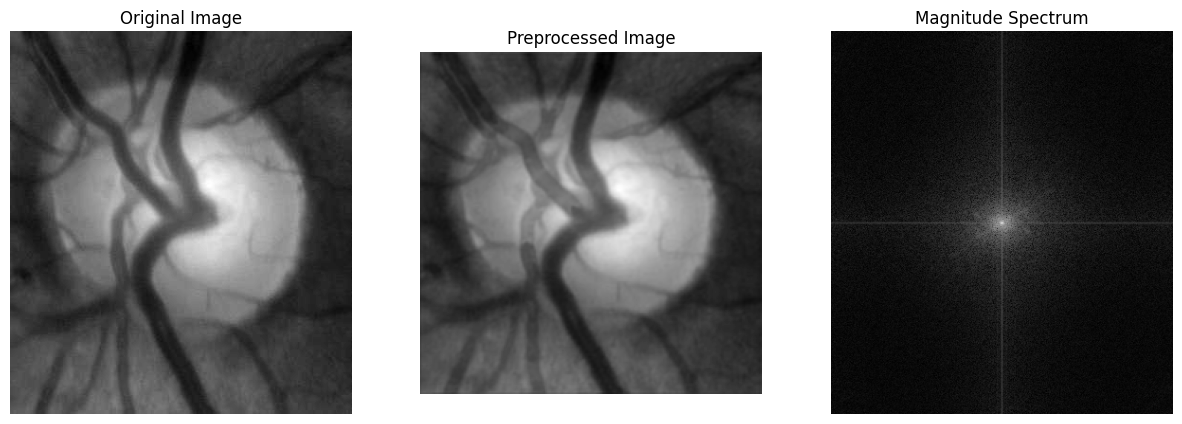

In [51]:
# Display the original and preprocessed images along with the magnitude spectrum
plt.figure(figsize=(15, 5))

# Display original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.imread(example_image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title("Original Image")
plt.axis("off")

# Display preprocessed image
plt.subplot(1, 3, 2)
plt.imshow(preprocessed_image, cmap='gray')
plt.title("Preprocessed Image")
plt.axis("off")

# Display magnitude spectrum
plt.subplot(1, 3, 3)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("Magnitude Spectrum")
plt.axis("off")

plt.show()

In [ ]:
# Function to save preprocessed image
def save_preprocessed_image(preprocessed_image, save_folder, custom_name):
    # Convert image to uint8 and scale pixel values to 0-255 range
    preprocessed_image_uint8 = (preprocessed_image * 255).astype(np.uint8)

    # Create the folder if it doesn't exist
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # Save the preprocessed image with the custom name
    save_path = os.path.join(save_folder, custom_name)
    cv2.imwrite(save_path, preprocessed_image_uint8)

    print("Preprocessed image saved successfully.")

In [ ]:
#save the image
custom_name = "glaucoma.jpg"
save_folder = "/content/drive/MyDrive/preprocessed_images"
save_preprocessed_image(preprocessed_image, save_folder, custom_name)

Preprocessed image saved successfully.
